In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb

import sys
sys.path.append('../')

from src.functions import Functions
from src.modeling import Modeling

import warnings
warnings.filterwarnings('ignore')

In [2]:
features = pd.read_csv('../data/raw_data/features.csv')
sales_train = pd.read_csv('../data/raw_data/train.csv')
stores = pd.read_csv('../data/raw_data/stores.csv')
sales_test = pd.read_csv('../data/raw_data/test.csv')

#### 特徴量の追加(1期先のIsHolidayを取得)

In [3]:
features['IsBeforeHoliday'] = features['IsHoliday'].shift(-1)
features['IsBeforeHoliday'].iloc[-1] = False

#### 欠損値の穴埋め

In [4]:
features = Functions.rollingInterpolation(features)

#### train, testのマージ

In [5]:
df_all_train = sales_train.merge(features, how="left", on=["Store","Date","IsHoliday"]).merge(stores, how="left", on=["Store"])
df_all_test = sales_test.merge(features, how="left", on=["Store","Date","IsHoliday"]).merge(stores, how="left", on=["Store"])

df_all_train['train_or_test'] = 'train'
df_all_test['train_or_test'] = 'test'
merged_df = pd.concat([df_all_train, df_all_test], sort=False)

merged_df = merged_df.sort_values(by=['Store','Dept','Date'], axis=0).reset_index().drop(columns='index')

#### カテゴリカルエンコーディング

In [6]:
merged_df = pd.get_dummies(merged_df, columns=["Type"])

LE = LabelEncoder()
merged_df['IsHoliday'] = LE.fit_transform(merged_df['IsHoliday'])

#### 休日の追加

In [7]:
merged_df = Functions.appendHolidayFlag(merged_df)

#### 時間に関する特徴量の追加

In [8]:
merged_df = Functions.addDateFeature(merged_df)

#### ラグ特徴量の追加

In [9]:
merged_df = Functions.createLagFeatures(merged_df)

#### 時間ごとの統計量に関する特徴量の追加

In [10]:
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Monthly_Sales_', ['Store','Dept', 'Month'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Daily_Sales_', ['Store','Dept', 'Day'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'WeekofMonth_Sales_', ['Store','Dept', 'WeekofMonth'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'WeekofYear_Sales_', ['Store','Dept', 'WeekofYear'])

#### 欠損の補間(-9999での補間は欠損値のまま取り扱うのに近い方法となるとの指摘)

In [11]:
merged_df = merged_df.fillna(-9999)

#### 特徴量をクラスタリングし、特徴量を追加

In [12]:
merged_df =  Functions.createClusteredFeatures(merged_df)

---------- 3  cluster ----------
Cluster :  0 Nums :  410439
Cluster :  1 Nums :  22619
Cluster :  2 Nums :  103576
---------- 5  cluster ----------
Cluster :  0 Nums :  322081
Cluster :  1 Nums :  22855
Cluster :  2 Nums :  56239
Cluster :  3 Nums :  5372
Cluster :  4 Nums :  130087
---------- 10  cluster ----------
Cluster :  0 Nums :  193413
Cluster :  1 Nums :  17073
Cluster :  2 Nums :  77698
Cluster :  3 Nums :  11129
Cluster :  4 Nums :  115888
Cluster :  5 Nums :  24686
Cluster :  6 Nums :  1790
Cluster :  7 Nums :  34763
Cluster :  8 Nums :  55463
Cluster :  9 Nums :  4731
---------- 15  cluster ----------
Cluster :  0 Nums :  50915
Cluster :  1 Nums :  9514
Cluster :  2 Nums :  112625
Cluster :  3 Nums :  16610
Cluster :  4 Nums :  32185
Cluster :  5 Nums :  1469
Cluster :  6 Nums :  23927
Cluster :  7 Nums :  2394
Cluster :  8 Nums :  12741
Cluster :  9 Nums :  94787
Cluster :  10 Nums :  5210
Cluster :  11 Nums :  98164
Cluster :  12 Nums :  67310
Cluster :  13 Nums :  4880

In [13]:
train = merged_df.loc[merged_df.train_or_test=='train', :]
test = merged_df.loc[merged_df.train_or_test=='test', :]

#### 学習

In [14]:
xgb_params =  {'n_estimators': [100],     
              'min_child_weight': np.arange(1, 10, 1),
              'max_depth': np.arange(3, 9, 1),
              'subsample': np.arange(0.6, 0.95, 0.05),
              'colsample_bytree': np.arange(0.6, 0.95, 0.05)}

In [15]:
from sklearn.model_selection import RandomizedSearchCV
rgr = xgb.XGBRegressor(random_state=2021)

train = train.drop(['Date', 'train_or_test'], axis=1)
test = test.drop(['Date', 'train_or_test'], axis=1)

pred = []
store_dept_list = test[['Store','Dept']].drop_duplicates().values.tolist()

for tempStore, tempDept in store_dept_list:
    print ('Store : ', tempStore, ' Dept :', tempDept)
    x_train = train[(train['Store'] == tempStore) & (train['Dept'] == tempDept)].drop(['Weekly_Sales'], axis=1)
    y_train = train[(train['Store'] == tempStore) & (train['Dept'] == tempDept)]['Weekly_Sales']
    x_test = test[(test['Store'] == tempStore) & (test['Dept'] == tempDept)].drop(['Weekly_Sales'], axis=1)
 
    if len(x_train) >= 5:

        rgr = RandomizedSearchCV(estimator=rgr, param_distributions = xgb_params, scoring='neg_root_mean_squared_error', 
                                 n_jobs=2, n_iter = 10, cv=5, verbose=5)
        rgr = rgr.fit(x_train, y_train)
        rgr = rgr.best_estimator_.fit(x_train, y_train)
        predict_test = rgr.predict(x_test)
        
        #fig, ax = plt.subplots(1, 1, figsize=(7, 25))
        #xgb.plot_importance(rgr,
        #                    importance_type='gain',
        #                    show_values=True,
        #                   ax=ax)
#
        #plt.show()
        

    elif len(x_train) >= 1:
        rgr = rgr.fit(x_train, y_train)
        predict_test = rgr.predict(x_test)
        
    else:
        predict_test = np.repeat(np.average(sales_train[sales_train['Dept'] == tempDept]['Weekly_Sales']), len(x_test))

    pred.extend(predict_test)

Store :  1  Dept : 1
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 2
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 3
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 4
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 6
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 7
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 8
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 9
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 10
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 11
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  Dept : 12
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Store :  1  D

In [16]:
ss = pd.read_csv('../data/raw_data/sampleSubmission.csv')
ss.loc[:, 'Weekly_Sales'] = pred
ss.to_csv('../files/submissions/XGB_rolling_52_104_0613_several_KM.csv', index=False)

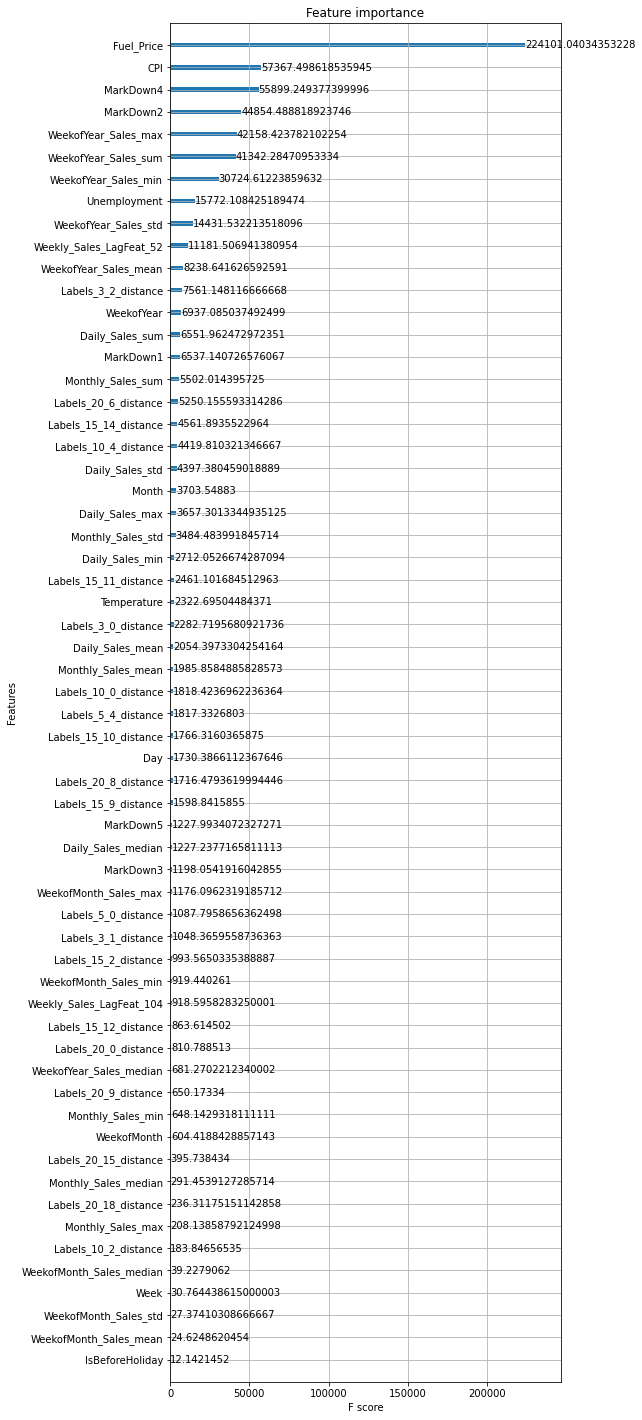

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
xgb.plot_importance(rgr,
                    importance_type='gain',
                    show_values=True,
                   ax=ax)

plt.show()